** Work in Progress -- starting to add commentary and tidy up **


I connected a [BMP180]() temperature and pressure centre to a
raspberry pi and have it running in my study.

I have been using this note book to look at the data as it is generated.

The code uses the Adafruit python library to extract data from the sensor.

I find plotting the data is a good way to take an initial look at it.

So, time for some pandas and matplotlib.

In [35]:
# Tell matplotlib to plot in line
%matplotlib inline

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()

In [36]:
# just check where I am
!pwd

/home/jng/devel/peakrisk/posts


In [37]:
infile = '../files/light.csv'

In [38]:
!scp 192.168.0.133:Adafruit_Python_BMP/light.csv .
!mv light.csv ../files

light.csv                                     100% 1043KB   1.0MB/s   00:00    


In [39]:
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

In [40]:
data.describe()

,temp,pressure,altitude,sealevel_pressure
count,15641.000000,15641.000000,15641.000000,15641.000000
mean,28.976920,101520.265009,-27.184538,101818.240841
std,4.046954,4264.685185,312.443798,3095.729562
min,-27.100000,28421.000000,-2749.583598,37537.000000
25%,28.200000,101719.000000,-49.253431,101721.000000
50%,28.800000,101823.000000,-41.378551,101824.000000
75%,29.400000,101918.000000,-32.833799,101919.000000
max,162.900000,128808.000000,7610.794710,139326.000000


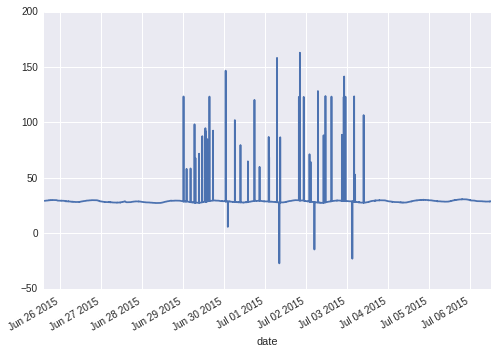

In [41]:
# Lets look at the temperature data
data.temp.plot()

Looks like we have some bad data here.  For the first few days things look ok though
To start, lets look at the good bit of the data.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b6c96d30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f96b58c4ac8>], dtype=object)

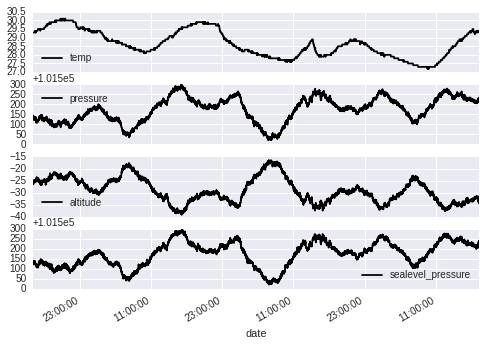

In [42]:
data[:4500].plot(subplots=True)

That looks good.  So for the first 4500 samples the data looks clean.

The pressure and sealevel_pressure plots have the same shape.

The sealevel_pressure is just the pressure recording adjusted for altitude.

Actually, since I am not telling the software what my altitude it is

It is a bit of a mystery what is causing the bad data after this.

One possibility is I have a separate process that is talking to the sensor that I am running in a console just so I can see the current figures.

I am running this with a linux *watch* command.   I used the default parameters and it is running every 2 seconds.

I am wondering if the sensor code, or the hardware itself has some bugs if the code polls the sensor whilst it is already being probed.

I am now (11am BDA time July 3rd) running the monitor script with *watch -n 600* so it only polls every 10 minutes.  Will see if that improves things.

So, lets see if we can filter out the bad data

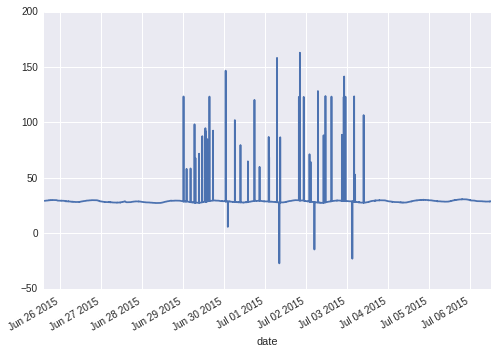

In [43]:
data.temp.plot()

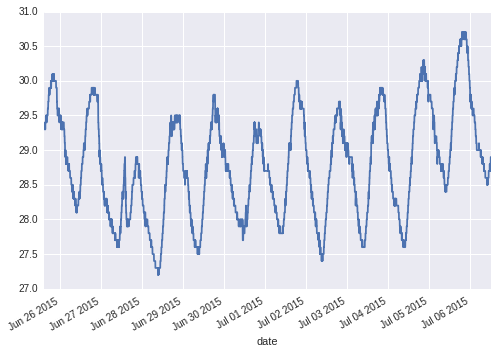

In [44]:
# All the good temperature readings appear to be in the 25C - 32C range,
# so lets filter out the rest.
data.temp[(data.temp < 50.0) & (data.temp > 15.0)].plot()

That looks good.  You can see 8 days of temperatures rising through the day and then falling at night.  Only a couple of degree difference here in Bermuda at present.

The Third day with the dip in temperature I believe there was a thunderstorm or two which cooled things off temporarily.

I really need to get a humidity sensor working to go with this.

Now lets see if we can spot the outliers and filter them out.


In [45]:
def spot_outliers(series):
    """ Compares the change in value in consecutive samples to the standard deviation

    If the change is bigger than that, assume it is an outlier.

    Note, that there will be two bad deltas, since the sample after the
    bad one will be bad too.
    """
    delta = series - series.shift()

    return delta.abs() > data.std()

outliers = spot_outliers(data)

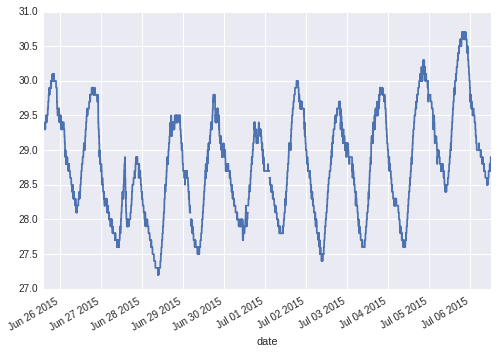

In [46]:
# Plot temperature
data[~outliers].temp.plot()

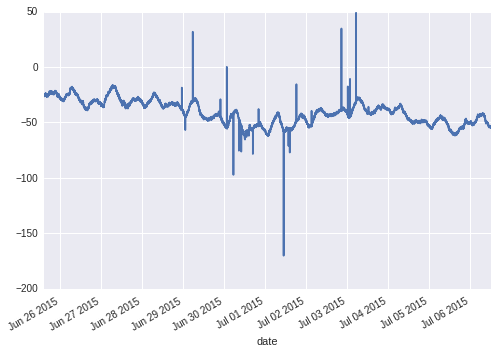

In [47]:
data[~outliers].altitude.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b577def0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f96b512f898>], dtype=object)

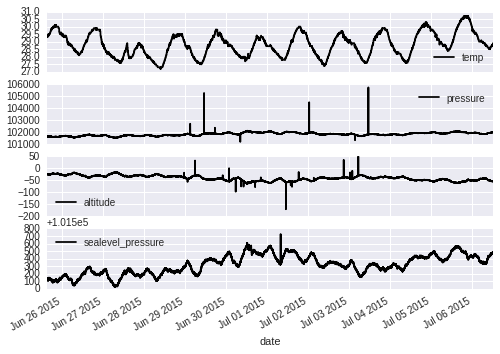

In [48]:
data[~outliers].plot(subplots=True)

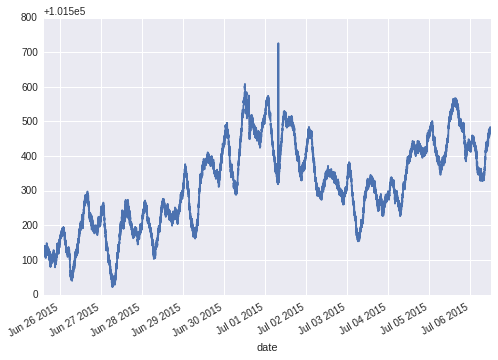

In [49]:
data[~outliers].sealevel_pressure.plot()

In [50]:
def smooth(data, thresh=None):
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    print(good.describe())
    
    return delta.where(good, 0.0)

               temp      pressure      altitude  sealevel_pressure
count  1.554800e+04  15324.000000  15364.000000       15368.000000
mean  -4.569994e-19      0.024602     -0.002342           0.027069
std    3.300908e-02     67.787309      2.369789           7.740331
min   -1.000000e-01  -3906.000000   -112.489928        -392.000000
25%    0.000000e+00     -4.000000     -0.331805          -4.000000
50%    0.000000e+00      0.000000      0.000000           0.000000
75%    0.000000e+00      4.000000      0.331750           4.000000
max    1.000000e-01   3906.000000    112.489928         400.000000


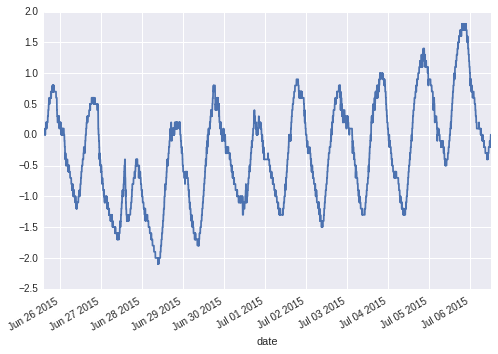

In [51]:
smooth(data).temp.cumsum().plot()

In [52]:
smooth(data).describe() 

               temp      pressure      altitude  sealevel_pressure
count  1.554800e+04  15324.000000  15364.000000       15368.000000
mean  -4.569994e-19      0.024602     -0.002342           0.027069
std    3.300908e-02     67.787309      2.369789           7.740331
min   -1.000000e-01  -3906.000000   -112.489928        -392.000000
25%    0.000000e+00     -4.000000     -0.331805          -4.000000
50%    0.000000e+00      0.000000      0.000000           0.000000
75%    0.000000e+00      4.000000      0.331750           4.000000
max    1.000000e-01   3906.000000    112.489928         400.000000


,temp,pressure,altitude,sealevel_pressure
count,1.564100e+04,15641.000000,15641.000000,15641.000000
mean,-4.542822e-19,0.024103,-0.002301,0.026597
std,3.291079e-02,67.096817,2.348710,7.672479
min,-1.000000e-01,-3906.000000,-112.489928,-392.000000
25%,0.000000e+00,-4.000000,-0.331683,-4.000000
50%,0.000000e+00,0.000000,0.000000,0.000000
75%,0.000000e+00,4.000000,0.331652,4.000000
max,1.000000e-01,3906.000000,112.489928,400.000000


               temp     pressure      altitude  sealevel_pressure
count  1.554800e+04  8202.000000  15324.000000        8184.000000
mean  -4.569994e-19     0.036942     -0.002413          -0.003177
std    3.300908e-02     2.458181      0.519410           2.458501
min   -1.000000e-01    -4.000000     -2.154588          -4.000000
25%    0.000000e+00    -2.000000     -0.331792          -2.000000
50%    0.000000e+00     0.000000      0.000000           0.000000
75%    0.000000e+00     2.000000      0.331728           2.000000
max    1.000000e-01     4.000000      2.240047           4.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f96b4f586d8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f96b4c64588>], dtype=object)

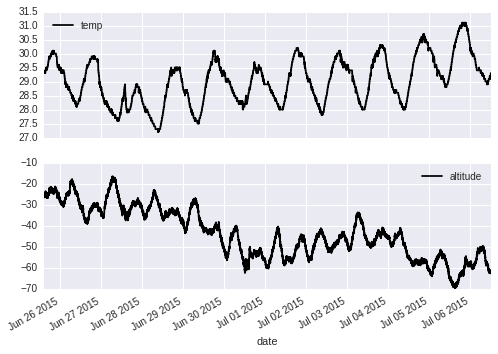

In [53]:
start = data[['temp', 'altitude']].irow(0)

(smooth(data, 5.0).cumsum()[['temp', 'altitude']] + start).plot(subplots=True)

*Bingo!* we have clean plots.
Of course the irony is that I also seem to have found the problem with
the bad data I was getting: don't have two processes querying these
sensors at the same time, at least not with the current software.  So
the recent data no longer needs this smoothing.



# Things to observe

So the daily rise and fall of temperature is pretty clear.  There is only 2C spread most days.

The pressure plot is more interesting.  Over the last week or so it
has been generally high, but there is an interesting wave feature.

The other day I was at the Bermduda Weather service and mentioned this
to Ian Currie, who immediately pointed out that air pressure is tidal.

So, my next plan is to dig out [scikit-learn]() and some lunar data,
maybe using *astropy* and see if we can fit a model to the pressure
data for the tidal component.